In [1]:
%config IPCompleter.use_jedi = False

In [24]:
import os
import shutil
import random
import json
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from IPython.display import HTML, display
from PIL import Image

%matplotlib inline

pd.set_option("display.precision", 3)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.max_rows", 50)
pd.set_option('max_colwidth',100)
pd.get_option('min_rows')

10

In [3]:
display(HTML('<style>.container { width:90% !important; }</style>'))

## Global Constants

In [108]:
DATA_ROOT = '/raceai/data/datasets/road_damage'
WORK_ROOT = DATA_ROOT

OUT_IMAGES_ROOT = f'{DATA_ROOT}/images'
OUT_LABELS_ROOT = f'{DATA_ROOT}/labels'

CITY_NAMES = ['Czech', 'India', 'Japan']
LABEL_NAMES = ['D00', 'D10', 'D20', 'D40']
TRAIN_VAL_SPLIT = 0.2

!ls -l $DATA_ROOT

total 4
drwxrwxr-x 5 1002 1002 4096 May 12  2020 train


In [42]:
!cat $DATA_ROOT/train/Japan/annotations/xmls/Japan_008191.xml

<annotation>
	<folder>images</folder>
	<filename>Japan_008191.jpg</filename>
	<size>
		<width>600</width>
		<height>600</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>D50</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>439</xmin>
			<ymin>360</ymin>
			<xmax>482</xmax>
			<ymax>372</ymax>
		</bndbox>
	</object>
</annotation>

## Prepare Data

In [129]:
def convert(size, box): # (w, h) (xmin, ymin, xmax, ymax)
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[2]) / 2.0
    y = (box[1] + box[3]) / 2.0
    w = box[2] - box[0]
    h = box[3] - box[1]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x,y,w,h]

In [216]:
train_city_data = {}

for city in CITY_NAMES:
    train_city_data[city] = []
    imgs_path = os.path.join(DATA_ROOT, 'train', city, 'images')
    anns_path = os.path.join(DATA_ROOT, 'train', city, 'annotations', 'xmls')
    for fil in os.listdir(anns_path):
        xml_fil = os.path.join(anns_path, fil)
        tree = ET.parse(xml_fil).getroot()
        img_fil = os.path.join(imgs_path, tree.find('filename').text)
        if not os.path.isfile(img_fil):
            continue
            
        img_w = int(tree.find('size/width').text)
        img_h = int(tree.find('size/height').text)
        
        bboxes = []
        for obj in tree.findall('object'):
            bbox = [int(child.text) for child in obj.find('bndbox')]
            name = obj.find('name').text
            if name in LABEL_NAMES:
                bboxes.append((LABEL_NAMES.index(name), convert((img_w, img_h), bbox), bbox))
        if len(bboxes) == 0:
            continue
        train_city_data[city].append((xml_fil, img_fil, bboxes))

In [131]:
for key, val in train_city_data.items():
    print(key, len(val))

Czech 1072
India 3223
Japan 7900


/raceai/data/datasets/road_damage/train/Japan/images/Japan_004111.jpg
/raceai/data/datasets/road_damage/train/Japan/images/Japan_010659.jpg
/raceai/data/datasets/road_damage/train/Japan/images/Japan_004302.jpg
/raceai/data/datasets/road_damage/train/Japan/images/Japan_005144.jpg
/raceai/data/datasets/road_damage/train/Japan/images/Japan_002175.jpg
/raceai/data/datasets/road_damage/train/Japan/images/Japan_005367.jpg
/raceai/data/datasets/road_damage/train/Japan/images/Japan_009340.jpg
/raceai/data/datasets/road_damage/train/Japan/images/Japan_006798.jpg
/raceai/data/datasets/road_damage/train/Japan/images/Japan_002865.jpg


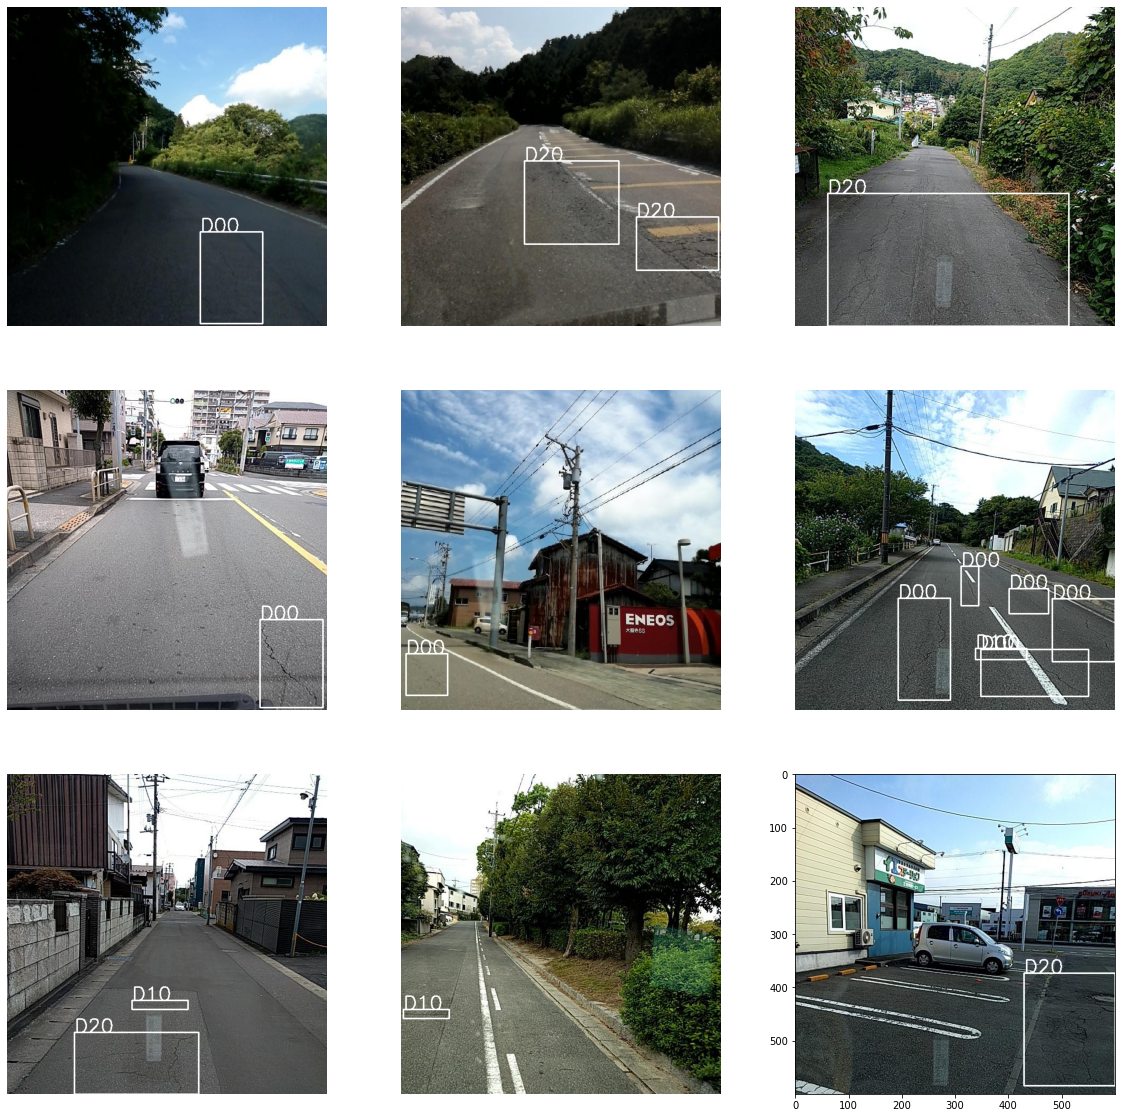

In [227]:
plt.figure(figsize=(20,20))
sample_images = random.sample(train_city_data['Japan'], 9)
for i, anns in enumerate(sample_images, 1):
    _, img_fil, boxes = anns
    print(img_fil)
    img = cv2.imread(img_fil)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    for lab, _, box in boxes:
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 255, 255), 2)
        cv2.putText(img, LABEL_NAMES[lab], (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)
    plt.axis('off')
    plt.subplot(3, 3, i)
    plt.imshow(img)

## Split Train & Val

In [159]:
train_data = {}
valid_data = {}

for city, anns in train_city_data.items():
    random.shuffle(anns)
    all_count = len(anns)
    val_count = int(all_count * TRAIN_VAL_SPLIT)
    train_data[city] = anns[:(all_count - val_count)]
    valid_data[city] = anns[-val_count:]

In [160]:
train_data['Japan'][0]

('/raceai/data/datasets/road_damage/train/Japan/annotations/xmls/Japan_006071.xml',
 '/raceai/data/datasets/road_damage/train/Japan/images/Japan_006071.jpg',
 [(2,
   [0.24250000000000002, 0.8275, 0.2316666666666667, 0.3416666666666667],
   [76, 394, 215, 599]),
  (0,
   [0.55, 0.8150000000000001, 0.15000000000000002, 0.2566666666666667],
   [285, 412, 375, 566]),
  (1,
   [0.10833333333333334,
    0.8383333333333334,
    0.2066666666666667,
    0.03666666666666667],
   [3, 492, 127, 514])])

## Convert to Yolov5 Format

In [162]:
for phase, data in [('train', train_data), ('val', valid_data)]:
    images_path = os.path.join(OUT_IMAGES_ROOT, phase)
    labels_path = os.path.join(OUT_LABELS_ROOT, phase)
    os.makedirs(images_path, exist_ok=True)
    os.makedirs(labels_path, exist_ok=True)
    for _, anns in data.items():
        for item in anns:
            xml_fil, img_fil, bboxes = item
            img_fil_name = os.path.basename(img_fil)
            xml_fil_name = img_fil_name.split('.')[0] + '.txt'
            shutil.copyfile(img_fil, os.path.join(images_path, img_fil_name))
            yolo_str = []
            for lab, bbox, _ in bboxes:
                x, y, w, h = bbox
                yolo_str.append('%d %.6f %.6f %.6f %.6f' % (lab, x, y, w, h))

            with open(os.path.join(labels_path, xml_fil_name), 'w') as f:
                f.write('\n'.join(yolo_str))